In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from six.moves import cPickle as pickle
%matplotlib inline

/home/josh/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read the training data

In [2]:
#pickle_file = 'train.pickle'
'''
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_1 = save['data']
    train_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
'''
    
pickle_file = 'train2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_0 = save['data']
    train_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory
    
'''
pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_1 = save['data']
    test_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
    
'''

pickle_file = 'test2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_0 = save['data']
    test_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory

In [3]:
#reformat the label
#for each digit, add a 'end_digit' as '10'
#for each label, add a digit size
#each of them is a one-hot coding

def label_reformat(label, max_size = 5):
    digit_size = np.asarray([len(x) for x in label])
    digit_size[digit_size > max_size]= max_size
    digit_size = ((np.arange(max_size)+1) == digit_size[:,None]).astype(np.float32)
    
    digits = {}
    end_digit = 10.0
    for i in range(max_size):
        digit_coding = np.asarray( [x[i] if len(x)>i else end_digit for x in label])
        digit_coding = (np.arange(end_digit+1) == digit_coding[:,None]).astype(np.float32)
        digits['digit_'+ str(i)] = digit_coding
        
    return digit_size, digits   

# sample a smaller data

In [4]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

In [5]:
train_X_0.shape

(33402, 64, 64, 3)

In [6]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

image_size = train_X_0.shape[1]
num_channels = train_X_0.shape[3]
batch_size = 200
val_size = 50
test_size = 50


#train_label = train_outcome_1['label'] +  train_outcome_2['label']
train_label = train_outcome_0['label'][:5000]
train_digit_size, train_digits = label_reformat(train_label)
train_X = train_X_0[:5000]


val_label = test_outcome_0['label'][:5000]
val_digit_size, val_digits = label_reformat(val_label)
val_X = test_X_0[:5000]

val_size = val_X.shape[0]

In [7]:
print train_digit_size.shape
print train_digits['digit_0'].shape
print train_X.shape

(5000, 5)
(5000, 11)
(5000, 64, 64, 3)


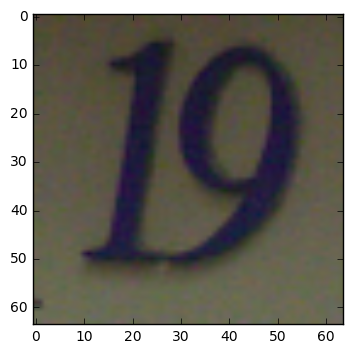

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [8]:
plt.imshow(train_X[0,:,:,:])
plt.show()
print train_digits['digit_0'][0]
print train_digits['digit_1'][0]

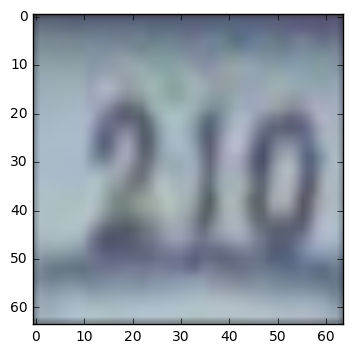

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
plt.imshow(val_X[1,:,:,:])
plt.show()
print val_digits['digit_0'][1]
print val_digits['digit_1'][1]

# start tensorflow session

In [10]:
def next_batch(X, y_dsize, y_ds, batch_size=50, replace = True):
    idx = np.random.choice(X.shape[0],batch_size, replace = replace)
    batch_x = X[idx,:,:,:]
    batch_y_dsize = y_dsize[idx,:]
    batch_y_d1 = y_ds['digit_0'][idx,:]
    batch_y_d2 = y_ds['digit_1'][idx,:]
    batch_y_d3 = y_ds['digit_2'][idx,:]
    batch_y_d4 = y_ds['digit_3'][idx,:]
    batch_y_d5 = y_ds['digit_4'][idx,:]
    
    return batch_x, batch_y_dsize, batch_y_d1, batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5


In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Build Graph

In [12]:
# shape = [None, ...], the None element of the shape corresponds to a variable-sized dimension.
x_image = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels])

y_d1 = tf.placeholder(tf.float32, shape=[None, 11])
y_d2 = tf.placeholder(tf.float32, shape=[None, 11])
y_d3 = tf.placeholder(tf.float32, shape=[None, 11])
y_d4 = tf.placeholder(tf.float32, shape=[None, 11])
y_d5 = tf.placeholder(tf.float32, shape=[None, 11])

y_dsize = tf.placeholder(tf.float32, shape=[None, 5])

# Small epsilon value for the BN transform
epsilon_BN = 1e-3

##  layer 1 with batch normalization: 

In [13]:
W_conv1_BN = weight_variable([5, 5, num_channels, 32])
b_conv1_BN = bias_variable([32])

z_conv1_BN = conv2d(x_image, W_conv1_BN) + b_conv1_BN

#calculate mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z_conv1_BN,[0,1,2])

# Apply the initial batch normalizing transform
z_conv1_hat = (z_conv1_BN - batch_mean1)/tf.sqrt(batch_var1 + epsilon_BN)

# Create two new parameters, scale and beta (shift)
# use .getshape() to set the shape of parameters
scale1 = tf.Variable(tf.ones(z_conv1_hat.get_shape()[-1]))
beta1 = tf.Variable(tf.zeros(z_conv1_hat.get_shape()[-1]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function
h_conv1 = tf.nn.relu(scale1 * z_conv1_hat + beta1)


#max pool
h_pool1 = max_pool_2x2(h_conv1)

## Layer 2 with BN, using Tensorflows built-in BN function

Note that tensorflow provides a tf.nn.batch_normalization. This code does the same thing as the code for layer 1 above.

In [14]:
W_conv2_BN = weight_variable([5, 5, 32, 64])
b_conv2_BN = bias_variable([64])

z_conv2_BN = conv2d(h_pool1, W_conv2_BN) + b_conv2_BN

#calculate mean and variance
#note here, use global normalization, axes = [0,1,2]
batch_mean2, batch_var2 = tf.nn.moments(z_conv2_BN,[0,1,2])

# Create two new parameters, scale and beta (shift)
# use .getshape() to set the shape of parameters. Here, get the last dimension
scale2 = tf.Variable(tf.ones(z_conv2_BN.get_shape()[-1]))
beta2 = tf.Variable(tf.zeros(z_conv2_BN.get_shape()[-1]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function
z_conv2 = tf.nn.batch_normalization(z_conv2_BN, batch_mean2, batch_var2, beta2, scale2, epsilon_BN )
h_conv2 = tf.nn.relu( z_conv2 )


#max pool
h_pool2 = max_pool_2x2(h_conv2)

## rest of graph
can also add BN for fully connect layer, but skip here

In [15]:
W_fc1 = weight_variable([16 * 16 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#first digit
W_fc2_d1 = weight_variable([1024, 11])
b_fc2_d1 = bias_variable([11])

y_conv_d1 = tf.matmul(h_fc1_drop, W_fc2_d1) + b_fc2_d1

#second digit
W_fc2_d2 = weight_variable([1024, 11])
b_fc2_d2 = bias_variable([11])

y_conv_d2 = tf.matmul(h_fc1_drop, W_fc2_d2) + b_fc2_d2

#third digit
W_fc2_d3 = weight_variable([1024, 11])
b_fc2_d3 = bias_variable([11])

y_conv_d3 = tf.matmul(h_fc1_drop, W_fc2_d3) + b_fc2_d3

#fourth digit
W_fc2_d4 = weight_variable([1024, 11])
b_fc2_d4 = bias_variable([11])

y_conv_d4 = tf.matmul(h_fc1_drop, W_fc2_d4) + b_fc2_d4

#fifth digit
W_fc2_d5 = weight_variable([1024, 11])
b_fc2_d5 = bias_variable([11])

y_conv_d5 = tf.matmul(h_fc1_drop, W_fc2_d5) + b_fc2_d5

#digit size
W_fc2_dsize = weight_variable([1024, 5])
b_fc2_dsize = bias_variable([5])

y_conv_dsize = tf.matmul(h_fc1_drop, W_fc2_dsize) + b_fc2_dsize


cross_entropy = ( tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d1, y_d1)) 
                 + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d2, y_d2))
                 + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d3, y_d3))
                 + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d4, y_d4))
                 + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d5, y_d5))
                 + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_dsize, y_dsize))
                 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#let's just check the first digit
correct_prediction = tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train model on a small data, see whether it overfit 
if overfit, then good. If not, check bugs.

In [21]:
num_steps = 4000
summary_frequency = 20

BNs_train, BNs_test, acc_train, acc_test = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(num_steps):
    (batch_x, batch_y_dsize, 
     batch_y_d1, batch_y_d2, 
     batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(train_X, 
                                                      train_digit_size,train_digits, batch_size)
    
    feed_dict={x_image: batch_x, y_dsize: batch_y_dsize,
               y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
               y_d4: batch_y_d4, y_d5: batch_y_d5, keep_prob: 0.5}
    
    train_step.run(feed_dict=feed_dict)
    
    if i%summary_frequency == 0:
        #train_accuracy = accuracy.eval(feed_dict=feed_dict)
        res_train = sess.run([accuracy,z_conv2],feed_dict=feed_dict)
        print("step %d, training accuracy %g"%(i, res_train[0]))
        
        acc_train.append(res_train[0])
        BNs_train.append(np.mean(res_train[1],axis=0).flatten()[:10])
        
        
        (batch_x, batch_y_dsize, batch_y_d1,
         batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, 
                                                                      val_digit_size, 
                                                                      val_digits, 
                                                                      batch_size, replace = False)
        feed_dict={x_image: batch_x, 
                   y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                   y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                   y_d5: batch_y_d5, keep_prob: 1}
        
        res = sess.run([accuracy,z_conv2],feed_dict=feed_dict)

        acc_test.append(res[0])

        # record the first 10 mean value of BN2 over the entire test set
        BNs_test.append(np.mean(res[1],axis=0).flatten()[:10]) 
        

BNs_train, BNs_test, acc_train, acc_test = ( np.array(BNs_train), 
                                            np.array(BNs_test), 
                                            np.array(acc_train), 
                                            np.array(acc_test) )


step 0, training accuracy 0.075
step 20, training accuracy 0.2
step 40, training accuracy 0.195
step 60, training accuracy 0.2
step 80, training accuracy 0.19
step 100, training accuracy 0.17
step 120, training accuracy 0.18
step 140, training accuracy 0.205
step 160, training accuracy 0.225
step 180, training accuracy 0.24
step 200, training accuracy 0.245
step 220, training accuracy 0.205
step 240, training accuracy 0.205
step 260, training accuracy 0.31
step 280, training accuracy 0.195
step 300, training accuracy 0.195
step 320, training accuracy 0.205
step 340, training accuracy 0.23
step 360, training accuracy 0.18
step 380, training accuracy 0.3
step 400, training accuracy 0.245
step 420, training accuracy 0.245
step 440, training accuracy 0.23
step 460, training accuracy 0.24
step 480, training accuracy 0.245
step 500, training accuracy 0.29
step 520, training accuracy 0.28
step 540, training accuracy 0.27
step 560, training accuracy 0.33
step 580, training accuracy 0.315
step 

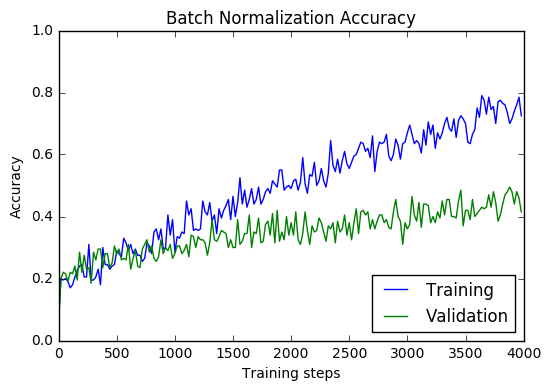

In [24]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc_train)*summary_frequency,summary_frequency),acc_train, label='Training')
ax.plot(range(0,len(acc_test)*summary_frequency,summary_frequency),acc_test, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

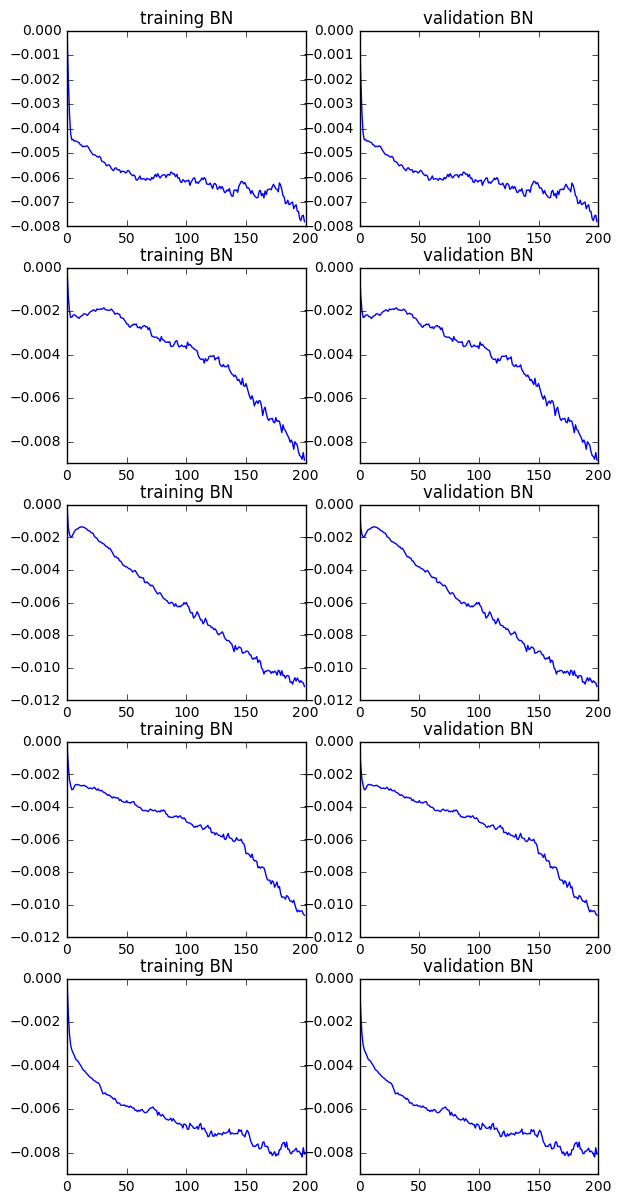

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("training BN")
    ax[1].set_title("validation BN")
    ax[0].plot(BNs_train[:,i])
    ax[1].plot(BNs_test[:,i])

prediction with BN is not right. Need addtional coding

In [28]:
predictions = []
correct = 0
for i in range(1000):
    
    (batch_x, batch_y_dsize, batch_y_d1, 
     batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, val_digit_size, val_digits, 
                                                                  1, replace = False)
    feed_dict={x_image: batch_x, 
                   y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                   y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                   y_d5: batch_y_d5, keep_prob: 1}
    
    corr = sess.run(accuracy,
                         feed_dict=feed_dict)
    correct += corr
    #predictions.append(pred[0])
#print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/1000)

('ACCURACY:', 0.30199999999999999)


In [73]:
# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
# http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
def batch_norm_wrapper(inputs, is_training, decay = 0.999, epsilon = 1e-3):

    scale = tf.Variable( tf.ones(inputs.get_shape()[-1]) )
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    if is_training:
        #for conv layer, use global normalization
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
        #print pop_mean.get_shape()
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

In [74]:
def build_graph(is_training):
    
    # shape = [None, ...], the None element of the shape corresponds to a variable-sized dimension.
    x_image = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels])
    
    y_d1 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d2 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d3 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d4 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d5 = tf.placeholder(tf.float32, shape=[None, 11])
    
    y_dsize = tf.placeholder(tf.float32, shape=[None, 5])
    

    #first layer
    W_conv1_BN = weight_variable([5, 5, num_channels, 32])
    b_conv1_BN = bias_variable([32])
    
    z_conv1_BN = conv2d(x_image, W_conv1_BN) + b_conv1_BN
    
    #print z_conv1_BN.get_shape()
    
    # Scale and shift to obtain the final output of the batch normalization
    # this value is fed into the activation function
    z_conv1 = batch_norm_wrapper(z_conv1_BN, is_training)
    h_conv1 = tf.nn.relu(z_conv1)
    
    
    #max pool
    h_pool1 = max_pool_2x2(h_conv1)
    

    #second layer
    W_conv2_BN = weight_variable([5, 5, 32, 64])
    b_conv2_BN = bias_variable([64])
    
    z_conv2_BN = conv2d(h_pool1, W_conv2_BN) + b_conv2_BN
    
    
    # Scale and shift to obtain the final output of the batch normalization
    # this value is fed into the activation function
    z_conv2 = batch_norm_wrapper(z_conv2_BN, is_training)
    h_conv2 = tf.nn.relu( z_conv2 )
    
    
    #max pool
    h_pool2 = max_pool_2x2(h_conv2)
    
    
    
    W_fc1 = weight_variable([16 * 16 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    #first digit
    W_fc2_d1 = weight_variable([1024, 11])
    b_fc2_d1 = bias_variable([11])
    
    y_conv_d1 = tf.matmul(h_fc1_drop, W_fc2_d1) + b_fc2_d1
    
    #second digit
    W_fc2_d2 = weight_variable([1024, 11])
    b_fc2_d2 = bias_variable([11])
    
    y_conv_d2 = tf.matmul(h_fc1_drop, W_fc2_d2) + b_fc2_d2
    
    #third digit
    W_fc2_d3 = weight_variable([1024, 11])
    b_fc2_d3 = bias_variable([11])
    
    y_conv_d3 = tf.matmul(h_fc1_drop, W_fc2_d3) + b_fc2_d3
    
    #fourth digit
    W_fc2_d4 = weight_variable([1024, 11])
    b_fc2_d4 = bias_variable([11])
    
    y_conv_d4 = tf.matmul(h_fc1_drop, W_fc2_d4) + b_fc2_d4
    
    #fifth digit
    W_fc2_d5 = weight_variable([1024, 11])
    b_fc2_d5 = bias_variable([11])
    
    y_conv_d5 = tf.matmul(h_fc1_drop, W_fc2_d5) + b_fc2_d5
    
    #digit size
    W_fc2_dsize = weight_variable([1024, 5])
    b_fc2_dsize = bias_variable([5])
    
    y_conv_dsize = tf.matmul(h_fc1_drop, W_fc2_dsize) + b_fc2_dsize
    
    
    cross_entropy = ( tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d1, y_d1)) 
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d2, y_d2))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d3, y_d3))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d4, y_d4))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d5, y_d5))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_dsize, y_dsize))
                     )
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    #let's just check the first digit
    correct_prediction = tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        


    return ( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob) , train_step, accuracy, z_conv2, tf.train.Saver())

In [75]:
#Build training graph, train and save the trained model

sess.close()
tf.reset_default_graph()

( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob), train_step, accuracy, z_conv2, saver) = build_graph(is_training=True)

num_steps = 4000
summary_frequency = 20

BNs_train, BNs_test, acc_train, acc_test = [], [], [], []


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(num_steps):
        (batch_x, batch_y_dsize, 
         batch_y_d1, batch_y_d2, 
         batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(train_X, 
                                                          train_digit_size,train_digits, batch_size)
    
        feed_dict={x_image: batch_x, y_dsize: batch_y_dsize,
                   y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
                   y_d4: batch_y_d4, y_d5: batch_y_d5, keep_prob: 0.5}
    
        train_step.run(feed_dict=feed_dict)
    
        if i%summary_frequency == 0:
            #train_accuracy = accuracy.eval(feed_dict=feed_dict)
            res_train = sess.run([accuracy,z_conv2],feed_dict=feed_dict)
            print("step %d, training accuracy %g"%(i, res_train[0]))
            
            acc_train.append(res_train[0])
            BNs_train.append(np.mean(res_train[1],axis=0).flatten()[:10])
            
            (batch_x, batch_y_dsize, batch_y_d1,
             batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, 
                                                                          val_digit_size, 
                                                                          val_digits, 
                                                                          batch_size, replace = False)
            feed_dict={x_image: batch_x, 
                       y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                       y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                       y_d5: batch_y_d5, keep_prob: 1}
        
            res = sess.run([accuracy,z_conv2],feed_dict=feed_dict)

            acc_test.append(res[0])

            # record the first 10 mean value of BN2 over the entire test set
            BNs_test.append(np.mean(res[1],axis=0).flatten()[:10])
        
    saved_model = saver.save(sess, 'temp-bn-save')

    
BNs_train, BNs_test, acc_train, acc_test = ( np.array(BNs_train), 
                                            np.array(BNs_test), 
                                            np.array(acc_train), 
                                            np.array(acc_test) )

(?, 64, 64, 32)
(32,)
(64,)
step 0, training accuracy 0.085
step 20, training accuracy 0.17
step 40, training accuracy 0.145
step 60, training accuracy 0.145
step 80, training accuracy 0.14
step 100, training accuracy 0.145
step 120, training accuracy 0.175
step 140, training accuracy 0.195
step 160, training accuracy 0.175
step 180, training accuracy 0.17
step 200, training accuracy 0.145
step 220, training accuracy 0.15
step 240, training accuracy 0.175
step 260, training accuracy 0.225
step 280, training accuracy 0.16
step 300, training accuracy 0.215
step 320, training accuracy 0.195
step 340, training accuracy 0.275
step 360, training accuracy 0.26
step 380, training accuracy 0.255
step 400, training accuracy 0.275
step 420, training accuracy 0.24
step 440, training accuracy 0.235
step 460, training accuracy 0.24
step 480, training accuracy 0.265
step 500, training accuracy 0.225
step 520, training accuracy 0.25
step 540, training accuracy 0.285
step 560, training accuracy 0.24
st

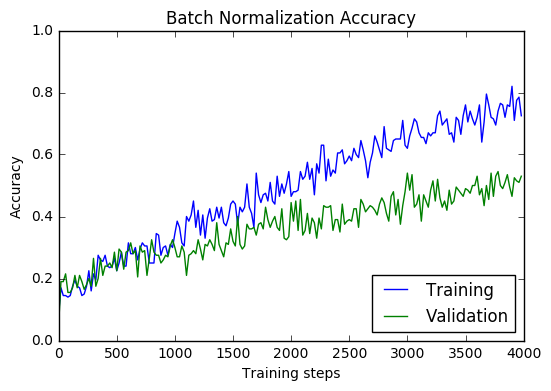

In [76]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc_train)*summary_frequency,summary_frequency),acc_train, label='Training')
ax.plot(range(0,len(acc_test)*summary_frequency,summary_frequency),acc_test, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [78]:

sess.close()
tf.reset_default_graph()
( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob), 
 train_step, accuracy, z_conv2, saver) = build_graph(is_training=False)

predictions = []
correct = 0

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, saved_model)
    for i in range(1000):
    
        (batch_x, batch_y_dsize, batch_y_d1, 
         batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, val_digit_size, val_digits, 
                                                                      1, replace = False)
        feed_dict={x_image: batch_x, 
                   y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                   y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                   y_d5: batch_y_d5, keep_prob: 1}
    
        corr = sess.run(accuracy,
                         feed_dict=feed_dict)
        correct += corr
    #predictions.append(pred[0])
#print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/1000)

(?, 64, 64, 32)
(32,)
(64,)
('ACCURACY:', 0.5)


In [61]:
a = [1,2,3,4]
a[-1]

4

In [63]:
a[1:]

[2, 3, 4]

In [72]:
[1]

[1]